In [1]:
# --- ONE-CELL RUNNER: Feature Extraction (Gamma + Canonical Bands) ---

from pathlib import Path
import sys, numpy as np, pandas as pd

# 0) Robustly find the repo root (folder that has 'src' and 'data')
def _find_repo_root(start: Path) -> Path:
    p = start.resolve()
    # Try current directory up to 5 parents
    for _ in range(6):
        if (p / "src").exists() and (p / "data").exists():
            return p
        p = p.parent
    # Common case: running from notebooks/
    if (start.parent / "src").exists():
        return start.parent
    return start  # fallback

CWD = Path.cwd()
REPO_ROOT = _find_repo_root(CWD)
print(f"CWD:        {CWD}")
print(f"Repo root:  {REPO_ROOT}")

# 1) Make src importable and ensure it's a package
sys.path.insert(0, str(REPO_ROOT))  # so "from src..." works
(REPO_ROOT / "src" / "__init__.py").touch(exist_ok=True)

# 2) Import the feature code
from src.fe_extract import (
    load_inputs, apply_good_channels, FeatureParams,
    features_broadband_gamma, features_canonical_bands, save_features
)

# 3) Point to where your teammate's files live
#    Expected files in this folder:
#      epochs.npy, time_vector.npy, stimcode.npy, good_channels.npy
DATA_DIR = REPO_ROOT / "data" / "derivatives"
print("Looking for data in:", DATA_DIR)
print("Files there:", sorted(p.name for p in DATA_DIR.glob("*")))


# 4) Load inputs (auto-reorders epochs to (trials, samples, channels) using time_vector length)
data = load_inputs(DATA_DIR)
epochs  = data["epochs"]    # (T, S, C)
time_ms = data["time_ms"]   # (S,)
labels  = data["labels"]    # (T,) or None
good    = data["good_ch"]   # (C,) or None

# Sanity prints
print("epochs shape (T,S,C):", epochs.shape)
print("time_vector length  :", None if time_ms is None else len(time_ms))
print("labels shape        :", None if labels is None else labels.shape)
print("good channels shape :", None if good is None else good.shape)

# 5) Keep only good channels (recommended)
epochs = apply_good_channels(epochs, good)
print("epochs after good_ch:", epochs.shape)

# 6) Configure feature params
#    If your teammate ALREADY baseline-zscored the epochs, keep epochs_are_zscored=True.
#    If not sure, set to False and we will z-score using (-300..0 ms) inside this cell.
params = FeatureParams(
    epochs_are_zscored=True,   # flip to False if you want us to re-baseline using (-300..0 ms)
    use_percent_change=False,  # set True if your team prefers % change over z-score
    baseline_ms=(-300.0, 0.0),
    feat_ms=(100.0, 400.0),
    gamma_band=(110.0, 140.0),
)

# 7) A) Broadband Gamma features (main)
fe_gamma = features_broadband_gamma(epochs, time_ms, params)
print("Gamma features:", fe_gamma.shape)  # (trials, n_good_channels)

# 8) B) Canonical Band features (optional comparison)
fe_bands = features_canonical_bands(epochs, time_ms, params, method="welch")
print("Canonical band features:", fe_bands.shape)  # (trials, n_good_channels * 4)

# 9) Save features + a compact CSV summary for teammates/plots
out_npz = save_features(DATA_DIR, fe_gamma, labels, params, band_feats=fe_bands)
print("Saved features to:", out_npz)

summary = pd.DataFrame({
    "trial": np.arange(fe_gamma.shape[0]),
    "label": (labels.astype(int) if labels is not None else -1),
    "mean_gamma": fe_gamma.mean(axis=1),
    "max_gamma": fe_gamma.max(axis=1),
    "n_channels_used": fe_gamma.shape[1],
})
summary_path = DATA_DIR / "feature_summary.csv"
summary.to_csv(summary_path, index=False)
print("Wrote:", summary_path)

# 10) Quick sanity assertions (fail fast if something is off)
assert fe_gamma.shape[0] == summary.shape[0], "Trials mismatch between features and summary."
assert not np.isnan(fe_gamma).any(), "NaNs found in gamma features."
assert not np.isinf(fe_gamma).any(), "Infs found in gamma features."
print("✅ Feature extraction finished cleanly.")


CWD:        c:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\notebooks
Repo root:  C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video
Looking for data in: C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\data\derivatives
Files there: ['epochs.npy', 'good_channels.npy', 'stimcode.npy', 'time_vector.npy']
epochs shape (T,S,C): (252, 840, 156)
time_vector length  : 840
labels shape        : (252,)
good channels shape : (156,)
epochs after good_ch: (252, 840, 153)
Gamma features: (252, 153)
Canonical band features: (252, 612)
Saved features to: C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\data\derivatives\trials_features.npz
Wrote: C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\data\derivatives\feature_summary.csv
✅ Feature extraction finished cleanly.


good min/max: 0 159


In [3]:
from pathlib import Path
import numpy as np

# Find repo root (folder that has 'src' and 'data')
def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(6):
        if (p / "src").exists() and (p / "data").exists():
            return p
        p = p.parent
    return start

CWD = Path.cwd()
REPO_ROOT = find_repo_root(CWD)
stim_path = REPO_ROOT / "data" / "derivatives" / "stimcode.npy"

print("Notebook CWD:", CWD)
print("Looking for:", stim_path)

if not stim_path.exists():
    print("⚠️ stimcode.npy not found there. Listing contents of derivatives:")
    deriv = REPO_ROOT / "data" / "derivatives"
    print([p.name for p in deriv.glob("*")])
else:
    stim = np.load(stim_path)
    print(f"Shape: {stim.shape}")
    unique, counts = np.unique(stim, return_counts=True)
    print("Unique values and counts:")
    for u, c in zip(unique, counts):
        print(f"  {u}: {c} trials")
    print("Total unique labels:", len(unique))




Notebook CWD: c:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\notebooks
Looking for: C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\data\derivatives\stimcode.npy
Shape: (252,)
Unique values and counts:
  2.0: 252 trials
Total unique labels: 1


RuntimeError: No matched diode events found within the allowed window. Check thresholds or increase max_match_diff_ms.

CWD: c:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\notebooks
Repo: C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video
trial_onsets shape: (252,), min/max: 12544–313646 (samples @ 1200.0 Hz)
video_diode shape : (7572,), inferred fps_video ≈ 30.048 Hz (~33.28 ms/frame)
Detected 126 video edges; 252 ECoG trial onsets.

[Event-time] matched=64  offset ≈ 409 samples (340.8 ms)  MAD=104.6 ms


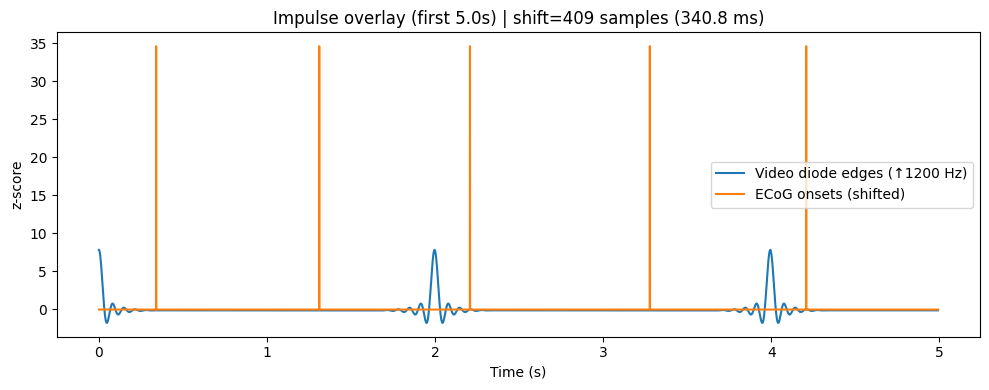

Saved overlay → C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\reports\figures\align_02_impulse_overlay.png

Compare to claim 534 samples: measured=409, Δ=-125 samples (-104.2 ms)


In [10]:
# ==== Offset via trial_onsets (ECoG) vs video_diode (Video) ====
# Self-contained: no other cells required

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample_poly

# ------------------ Find repo root & paths ------------------
def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(6):
        if (p / "src").exists() and (p / "data").exists():
            return p
        p = p.parent
    return start

CWD = Path.cwd()
REPO = find_repo_root(CWD)
DER  = REPO / "data" / "derivatives"
FIGS = REPO / "reports" / "figures"
FIGS.mkdir(parents=True, exist_ok=True)

fs_ecog = 1200.0           # known ECoG sampling rate
video_duration_s = 252.0   # from paradigm XML

# ------------------ Load what we need ------------------
trial_onsets = np.load(DER / "trial_onsets.npy")   # ECoG sample indices of events (photodiode-derived)
video_diode  = np.load(DER / "video_diode.npy")    # ~FPS vector from video frames

fps_video = len(video_diode) / video_duration_s
print(f"CWD: {CWD}\nRepo: {REPO}")
print(f"trial_onsets shape: {trial_onsets.shape}, min/max: {trial_onsets.min()}–{trial_onsets.max()} (samples @ {fs_ecog} Hz)")
print(f"video_diode shape : {video_diode.shape}, inferred fps_video ≈ {fps_video:.3f} Hz (~{1000/fps_video:.2f} ms/frame)")

# ------------------ Detect rising edges in video_diode ------------------
def detect_edges_hysteresis(x, fs, low_q=1, high_q=99, arm=0.6, disarm=0.2, min_isi_ms=20.0):
    """Rising-edge detector with hysteresis + debounce (works for analog/binary)."""
    x = np.asarray(x, float)
    lo, hi = np.percentile(x, [low_q, high_q])
    if hi <= lo:
        hi = lo + 1.0
    xn = np.clip((x - lo) / (hi - lo), 0, 1)
    armed = True; last = -10**9; edges = []
    min_isi = int(round(min_isi_ms/1000.0 * fs))
    for i in range(1, len(xn)):
        if armed and xn[i-1] < arm <= xn[i]:
            if i - last >= min_isi:
                edges.append(i); last = i; armed = False
        elif not armed and xn[i] < disarm:
            armed = True
    return np.asarray(edges, int)

edges_video = detect_edges_hysteresis(video_diode, fs=fps_video, min_isi_ms=25.0)
t_ecog  = trial_onsets / fs_ecog          # seconds
t_video = edges_video / fps_video         # seconds

print(f"Detected {len(edges_video)} video edges; {len(trial_onsets)} ECoG trial onsets.")

# ------------------ Match events to estimate offset ------------------
def match_nearest(t_ref, t_qry, max_diff_s=0.5):
    """Match nearest events (sorted arrays) within ±max_diff_s; returns diffs = t_qry - t_ref."""
    i = j = 0; IR=[]; IQ=[]; D=[]
    while i < len(t_ref) and j < len(t_qry):
        dt = t_qry[j] - t_ref[i]
        if abs(dt) <= max_diff_s:
            IR.append(i); IQ.append(j); D.append(dt); i+=1; j+=1
        elif t_ref[i] < t_qry[j]:
            i += 1
        else:
            j += 1
    return np.asarray(IR), np.asarray(IQ), np.asarray(D)

# We don't know 1:1 correspondence; use the first K events to be conservative (e.g., K=min(len,t))
K = min(len(t_ecog), len(t_video))
IR, IQ, diffs = match_nearest(t_ref=t_video[:K], t_qry=t_ecog[:K], max_diff_s=0.5)  # allow ±500 ms

if diffs.size == 0:
    raise RuntimeError("No matched events within ±500 ms. Increase window or check signals.")

offset_s = float(np.median(diffs))             # ecog_time - video_time (seconds)
offset_samples = int(round(offset_s * fs_ecog))

mad_ms = float(np.median(np.abs(diffs - offset_s)) * 1000.0)
print(f"\n[Event-time] matched={len(diffs)}  offset ≈ {offset_samples} samples ({offset_samples/fs_ecog*1000:.1f} ms)  MAD={mad_ms:.1f} ms")

# ------------------ Visual sanity overlay (impulse trains) ------------------
# Make short impulse trains (first N seconds) to visualize alignment after shifting
seconds = 5.0
n_ecog = int(seconds * fs_ecog)
n_vid  = int(seconds * fps_video)

# Build impulse trains
imp_ecog = np.zeros(n_ecog, dtype=float)
# Shift ECoG impulses by offset so they align to video time
shift = offset_samples
# Keep only onsets within first window after shift
on = trial_onsets - trial_onsets.min()  # start at ~0
on_shifted = on + shift
on_mask = (on_shifted >= 0) & (on_shifted < n_ecog)
imp_ecog[on_shifted[on_mask]] = 1.0

# Video impulses from rising edges
imp_vid_30 = np.zeros(n_vid, dtype=float)
ev = edges_video - edges_video.min()  # start at ~0
vmask = (ev >= 0) & (ev < n_vid)
imp_vid_30[ev[vmask]] = 1.0

# Upsample video impulses to 1200 Hz to overlay
from math import gcd
up = int(round(fs_ecog*1000)); down = int(round(fps_video*1000)); g = gcd(up, down)
imp_vid_1200 = resample_poly(imp_vid_30, up//g, down//g)
N = min(len(imp_vid_1200), len(imp_ecog))
t = np.arange(N) / fs_ecog

z = lambda a: (a - a.mean()) / (a.std() + 1e-12)
plt.figure(figsize=(10,4))
plt.plot(t, z(imp_vid_1200[:N]), label="Video diode edges (↑1200 Hz)")
plt.plot(t, z(imp_ecog[:N]),     label="ECoG onsets (shifted)")
plt.title(f"Impulse overlay (first {seconds:.1f}s) | shift={offset_samples} samples ({offset_samples/fs_ecog*1000:.1f} ms)")
plt.xlabel("Time (s)"); plt.ylabel("z-score"); plt.legend(); plt.tight_layout()
outp = FIGS / "align_02_impulse_overlay.png"
plt.savefig(outp, dpi=150); plt.show()
print(f"Saved overlay → {outp}")

# ------------------ Compare to teammate's claim (534 samples) ------------------
claimed = 534
delta = offset_samples - claimed
print(f"\nCompare to claim 534 samples: measured={offset_samples}, Δ={delta} samples ({delta/fs_ecog*1000:.1f} ms)")


CWD: c:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\notebooks
Repo: C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video
trial_onsets.shape=(252,), min/max=12544–313646 (samples @ 1200.0 Hz)
video_diode.shape=(7572,), inferred fps_video≈30.048 Hz (~33.28 ms/frame)
Detected video rising edges: 126

Phase A (even onsets):
{'matched': 51, 'offset_samples': 505, 'offset_ms': 420.8333333333333, 'mad_ms': 35.69862651875155, 'intercept_s': 0.0013352543054397632, 'slope': 0.3385697171708037, 'residual_ms_p50': 19869.070820691675}
Phase B (odd onsets):
{'matched': 88, 'offset_samples': -425, 'offset_ms': -354.1666666666667, 'mad_ms': 76.47913365028103, 'intercept_s': 0.0014767811682160979, 'slope': -0.60125325807474, 'residual_ms_p50': 98690.41229997686}

→ Selected phase: ODD  (matched=88, offset≈-425 samples, MAD=76.5 ms)
Estimated drift slope ≈ -6.013e-01 s/s  (~-601253.3 ppm); residual median=98690.4 ms


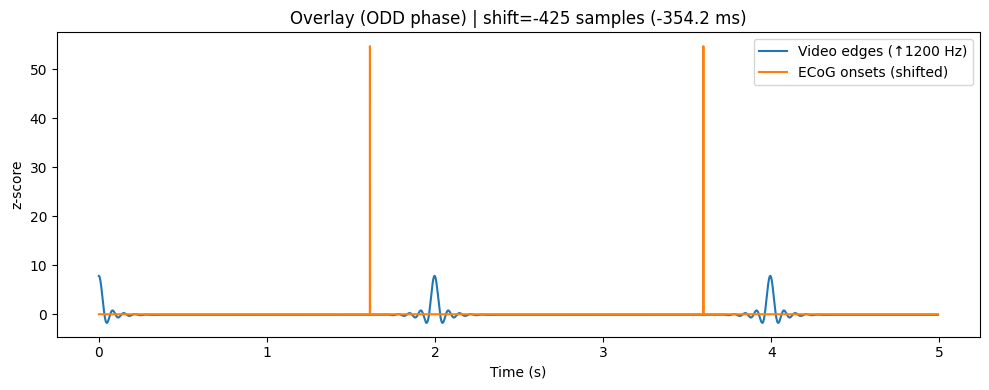

Saved overlay → C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\reports\figures\align_phase_overlay.png
Saved alignment parameters → C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\data\derivatives\alignment_offset.json


In [11]:
# ==== Try both onset phases (even vs odd), pick best, estimate offset (+ optional drift) ====
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample_poly

# ------------------ Paths & constants ------------------
def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(6):
        if (p / "src").exists() and (p / "data").exists():
            return p
        p = p.parent
    return start

CWD = Path.cwd()
REPO = find_repo_root(CWD)
DER  = REPO / "data" / "derivatives"
FIGS = REPO / "reports" / "figures"
FIGS.mkdir(parents=True, exist_ok=True)

fs_ecog         = 1200.0
video_duration_s = 252.0  # from XML

# ------------------ Load inputs ------------------
trial_onsets = np.load(DER / "trial_onsets.npy")   # ECoG sample indices (rising+falling mixed)
video_diode  = np.load(DER / "video_diode.npy")    # extracted from video
fps_video = len(video_diode) / video_duration_s

print(f"CWD: {CWD}\nRepo: {REPO}")
print(f"trial_onsets.shape={trial_onsets.shape}, min/max={trial_onsets.min()}–{trial_onsets.max()} (samples @ {fs_ecog} Hz)")
print(f"video_diode.shape={video_diode.shape}, inferred fps_video≈{fps_video:.3f} Hz (~{1000/fps_video:.2f} ms/frame)")

# ------------------ Helpers ------------------
def detect_edges_hysteresis(x, fs, low_q=1, high_q=99, arm=0.6, disarm=0.2, min_isi_ms=20.0):
    """Rising-edge detector with hysteresis + debounce (robust to analog/binary)."""
    x = np.asarray(x, float)
    lo, hi = np.percentile(x, [low_q, high_q])
    if hi <= lo:
        hi = lo + 1.0
    xn = np.clip((x - lo) / (hi - lo), 0, 1)
    armed = True; last = -10**9; edges=[]
    min_isi = int(round(min_isi_ms/1000.0 * fs))
    for i in range(1, len(xn)):
        if armed and xn[i-1] < arm <= xn[i]:
            if i - last >= min_isi:
                edges.append(i); last = i; armed = False
        elif not armed and xn[i] < disarm:
            armed = True
    return np.asarray(edges, int)

def match_nearest(t_ref, t_qry, max_diff_s=0.5):
    """Match nearest events between sorted arrays (seconds), within ±max_diff_s."""
    i=j=0; IR=[]; IQ=[]; D=[]
    while i < len(t_ref) and j < len(t_qry):
        dt = t_qry[j] - t_ref[i]
        if abs(dt) <= max_diff_s:
            IR.append(i); IQ.append(j); D.append(dt); i+=1; j+=1
        elif t_ref[i] < t_qry[j]:
            i+=1
        else:
            j+=1
    return np.asarray(IR), np.asarray(IQ), np.asarray(D)

def evaluate_phase(onsets_samples: np.ndarray, edges_video: np.ndarray, fs_ecog: float, fps_video: float, max_diff_s: float = 0.5):
    """Return dict with metrics for this onset phase."""
    t_ecog  = onsets_samples / fs_ecog
    t_video = edges_video / fps_video
    K = min(len(t_ecog), len(t_video))  # be conservative
    IR, IQ, diffs = match_nearest(t_video[:K], t_ecog[:K], max_diff_s=max_diff_s)
    if diffs.size == 0:
        return {"matched": 0}
    # ecog_time - video_time (seconds)
    offset_s = float(np.median(diffs))
    offset_samples = int(round(offset_s * fs_ecog))
    mad_ms = float(np.median(np.abs(diffs - offset_s)) * 1000.0)
    # Optional drift: fit diffs = a + b * t_video
    tv = t_video[IR]
    a, b = np.polyfit(tv, diffs, 1)  # b = drift slope (s per s), a = intercept (s)
    return {
        "matched": len(diffs),
        "offset_samples": offset_samples,
        "offset_ms": offset_samples / fs_ecog * 1000.0,
        "mad_ms": mad_ms,
        "intercept_s": float(a),
        "slope": float(b),  # if nonzero, clocks drift slightly
        "residual_ms_p50": float(np.median(np.abs(diffs - (a + b*tv)) * 1000.0)),
    }

def overlay_impulses(onsets_samples: np.ndarray, edges_video: np.ndarray, shift_samples: int, fs_ecog: float, fps_video: float, seconds: float = 5.0, title: str = ""):
    """Visual overlay using impulse trains (video ↑1200 Hz, ECoG shifted by offset)."""
    n_ecog = int(seconds * fs_ecog)
    n_vid  = int(seconds * fps_video)
    imp_ecog = np.zeros(n_ecog, float)
    # shift onsets by 'shift_samples' relative to video time base
    on = onsets_samples - onsets_samples.min()
    on_shift = on + shift_samples
    mask = (on_shift >= 0) & (on_shift < n_ecog)
    imp_ecog[on_shift[mask]] = 1.0

    imp_vid_30 = np.zeros(n_vid, float)
    ev = edges_video - edges_video.min()
    vmask = (ev >= 0) & (ev < n_vid)
    imp_vid_30[ev[vmask]] = 1.0

    # upsample video impulses to 1200 Hz for overlay
    from math import gcd
    up = int(round(fs_ecog*1000)); down = int(round(fps_video*1000)); g = gcd(up, down)
    imp_vid_1200 = resample_poly(imp_vid_30, up//g, down//g)

    N = min(len(imp_vid_1200), len(imp_ecog))
    t = np.arange(N) / fs_ecog
    z = lambda a: (a - a.mean()) / (a.std() + 1e-12)

    plt.figure(figsize=(10,4))
    plt.plot(t, z(imp_vid_1200[:N]), label="Video edges (↑1200 Hz)")
    plt.plot(t, z(imp_ecog[:N]),     label="ECoG onsets (shifted)")
    plt.xlabel("Time (s)"); plt.ylabel("z-score")
    ttl = title if title else f"Overlay | shift={shift_samples} samples ({shift_samples/fs_ecog*1000:.1f} ms)"
    plt.title(ttl); plt.legend(); plt.tight_layout()
    outp = FIGS / "align_phase_overlay.png"
    plt.savefig(outp, dpi=150); plt.show()
    print(f"Saved overlay → {outp}")

# ------------------ Detect video edges ------------------
edges_video = detect_edges_hysteresis(video_diode, fs=fps_video, min_isi_ms=25.0)
print(f"Detected video rising edges: {len(edges_video)}")

# ------------------ Evaluate both phases ------------------
onsets_even = trial_onsets[::2]
onsets_odd  = trial_onsets[1::2]

m_even = evaluate_phase(onsets_even, edges_video, fs_ecog, fps_video, max_diff_s=0.5)
m_odd  = evaluate_phase(onsets_odd,  edges_video, fs_ecog, fps_video, max_diff_s=0.5)

print("\nPhase A (even onsets):")
print(m_even)
print("Phase B (odd onsets):")
print(m_odd)

# Choose best: higher matched first, then lower MAD / residual
def score(m):
    if m.get("matched", 0) == 0:
        return (-1, float("inf"))
    return (m["matched"], -m["mad_ms"])  # higher matched, lower mad

best_phase = "even" if score(m_even) >= score(m_odd) else "odd"
best = m_even if best_phase == "even" else m_odd
print(f"\n→ Selected phase: {best_phase.upper()}  (matched={best['matched']}, offset≈{best['offset_samples']} samples, MAD={best['mad_ms']:.1f} ms)")

# ------------------ Optional drift check ------------------
# If |slope| > ~1e-4, there may be slight clock drift; we record it for reference.
drift_ppm = best["slope"] * 1e6  # parts per million (approx)
print(f"Estimated drift slope ≈ {best['slope']:.3e} s/s  (~{drift_ppm:.1f} ppm); residual median={best['residual_ms_p50']:.1f} ms")

# ------------------ Overlay with chosen offset ------------------
chosen_onsets = onsets_even if best_phase == "even" else onsets_odd
overlay_impulses(
    onsets_samples=chosen_onsets,
    edges_video=edges_video,
    shift_samples=best["offset_samples"],
    fs_ecog=fs_ecog,
    fps_video=fps_video,
    seconds=5.0,
    title=f"Overlay ({best_phase.upper()} phase) | shift={best['offset_samples']} samples ({best['offset_ms']:.1f} ms)"
)

# ------------------ Save JSON so everyone can reuse ------------------
import json
out = {
    "phase": best_phase,
    "offset_samples_ecog": int(best["offset_samples"]),
    "offset_seconds": best["offset_samples"] / fs_ecog,
    "fs_ecog": fs_ecog,
    "fps_video": fps_video,
    "matched_events": int(best["matched"]),
    "mad_ms": float(best["mad_ms"]),
    "drift_s_per_s": float(best["slope"]),
    "residual_ms_p50": float(best["residual_ms_p50"]),
    "notes": "Offset estimated by matching trial_onsets (ECoG) to rising edges in video_diode (video).",
}
with open(DER / "alignment_offset.json", "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2)
print(f"Saved alignment parameters → {DER / 'alignment_offset.json'}")


In [3]:
# === A. Continuous high-gamma (HG) envelope from filtered_data.npy ===
# - loads continuous ECoG
# - selects good channels
# - bandpass (110–140 Hz) + Hilbert amplitude (+ optional smoothing)
# - applies global offset (align to video time)
# - saves cache: data/derivatives/continuous_hg_env.npz

from pathlib import Path
import sys, numpy as np
from scipy.signal import butter, filtfilt, hilbert
import json

# Make repo root importable and load config
REPO_ROOT = Path.cwd().parent
sys.path.insert(0, str(REPO_ROOT))
from src import config as C

print("Config:", C.describe())

# ---------- Helper functions (kept local so this cell is self-contained) ----------
def ensure_TxC(x: np.ndarray) -> np.ndarray:
    """Ensure array is (time, channels). Accepts (channels, time) and transposes."""
    if x.ndim != 2:
        raise ValueError(f"Expected 2D array, got {x.shape}")
    # Heuristic: more samples than channels → likely (time, channels)
    if x.shape[0] < x.shape[1]:
        # probably (channels, samples) → transpose
        return x.T
    return x

def bandpass_filtfilt(x: np.ndarray, fs: float, lo: float, hi: float, order: int = 4) -> np.ndarray:
    """Zero-phase IIR bandpass across time axis (axis=0). x is (time, channels)."""
    ny = fs / 2.0
    if not (0 < lo < hi < ny):
        raise ValueError(f"Invalid band [{lo}, {hi}] for fs={fs}")
    b, a = butter(order, [lo/ny, hi/ny], btype="band")
    return filtfilt(b, a, x, axis=0)

def moving_avg_1d(x: np.ndarray, win_samples: int) -> np.ndarray:
    """Simple causal-insensitive moving average (centered via reflect padding)."""
    if win_samples <= 1:
        return x
    pad = win_samples // 2
    xpad = np.pad(x, ((pad, pad), (0, 0)), mode="reflect")
    k = np.ones((win_samples, ), dtype=float) / float(win_samples)
    # convolve each channel separately (time domain)
    y = np.empty_like(xpad, dtype=float)
    for ch in range(x.shape[1]):
        y[:, ch] = np.convolve(xpad[:, ch], k, mode="same")
    return y[pad:-pad, :]

def shift_samples_TxC(x: np.ndarray, shift: int) -> np.ndarray:
    """Shift along time (axis=0). Positive shift -> move forward in time (pad with edge)."""
    if shift == 0:
        return x
    y = np.empty_like(x)
    if shift > 0:
        y[:shift, :] = x[0:1, :]
        y[shift:, :] = x[:-shift, :]
    else:
        s = -shift
        y[-s:, :] = x[-1:, :]
        y[:-s, :] = x[s:, :]
    return y

# ---------- Load continuous data & good channels ----------
cont = np.load(C.FILTERED_CONTINUOUS_NPY, mmap_mode=None)  # load into RAM
X = np.asarray(cont, dtype=np.float32)  # <- allow copy if needed (NumPy 2.x friendly)
X = ensure_TxC(X)  # (time, channels)


print(f"Continuous data shape (time, channels): {X.shape}")

good_idx = C.load_good_channels(C.GOOD_CHANNELS_NPY, n_channels=X.shape[1])
print(f"Good channels: {len(good_idx)} (0-based). Example: {good_idx[:8]}")

X = X[:, good_idx]  # keep only good channels

# ---------- High-gamma envelope ----------
fs = C.FS
lo, hi = C.HG_BAND
print(f"Bandpass {lo}-{hi} Hz @ {fs} Hz ...")
X_bp = bandpass_filtfilt(X, fs=fs, lo=lo, hi=hi)

# Hilbert amplitude (envelope)
amp = np.abs(hilbert(X_bp, axis=0)).astype(np.float32)

# Optional smoothing (for stability)
win_ms = float(C.HG_SMOOTH_MS)
win_samples = max(1, int(round(win_ms / 1000.0 * fs)))
if win_samples > 1:
    print(f"Smoothing envelope with {win_ms} ms (~{win_samples} samples) moving average ...")
    amp = moving_avg_1d(amp, win_samples)

# ---------- Apply global alignment offset (ECoG -> video time) ----------
shift = int(C.ALIGNMENT_OFFSET_SAMPLES)
print(f"Applying alignment offset: {shift} samples ({shift/fs*1000:.1f} ms)")
amp_aligned = shift_samples_TxC(amp, shift)

# ---------- Save cache (NPZ + JSON sidecar) ----------

out_path = C.CONT_HG_ENV_NPZ
meta = {
    "fs": fs,
    "hg_band": [lo, hi],
    "smooth_ms": win_ms,
    "alignment_offset_samples": shift,
    "channels_used_0b": good_idx.tolist(),
    "input_file": str(C.FILTERED_CONTINUOUS_NPY),
}

# 1) save numeric arrays only (NumPy 2.x friendly)
np.savez_compressed(
    out_path,
    env=amp_aligned.astype(np.float32),      # (time, n_good_channels)
    fs=np.array([fs], dtype=np.float32),
    offset_samples=np.array([shift], dtype=np.int32),
    channels_used=np.array(good_idx, dtype=np.int32),
)
print(f"Saved continuous HG envelope → {out_path}")

# 2) write human-readable metadata next to it
json_path = out_path.with_suffix(".json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)
print(f"Saved metadata → {json_path}")



# ---------- Tiny sanity prints ----------
env = amp_aligned  # alias
print("Envelope mean (first 5s):", float(env[:int(5*fs)].mean()))
print("Envelope shape:", env.shape)


Config: {'repo_root': 'C:\\Users\\aryan\\iCloudDrive\\gtec hackathon\\ecog-video', 'fs_ecog': 1200.0, 'fps_video_nominal': 30.0, 'alignment_offset_samples': -425, 'hg_band': (110.0, 140.0), 'baseline_ms': (-300.0, 0.0), 'response_ms': (100.0, 400.0), 'welch_window_ms': 256.0, 'derivatives_dir': 'C:\\Users\\aryan\\iCloudDrive\\gtec hackathon\\ecog-video\\data\\derivatives'}
Continuous data shape (time, channels): (322049, 160)
Good channels: 156 (0-based). Example: [0 1 2 3 4 5 6 7]
Bandpass 110.0-140.0 Hz @ 1200.0 Hz ...
Smoothing envelope with 25.0 ms (~30 samples) moving average ...
Applying alignment offset: -425 samples (-354.2 ms)
Saved continuous HG envelope → C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\data\derivatives\continuous_hg_env.npz
Saved metadata → C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\data\derivatives\continuous_hg_env.json
Envelope mean (first 5s): 3.103247407545637
Envelope shape: (322049, 156)
